# Install Dependencies


In [6]:
!pip install rfdetr supervision pycocotools matplotlib opencv-python roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 21.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 21.4 MB/s eta 0:00:00
Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (422 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.4/837.4 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.6 MB

# Import Libraries

In [7]:
from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES
import torch
from PIL import Image
import supervision as sv
import os
import random
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from tqdm import tqdm

# Dataset from Roboflow
Dataset: https://universe.roboflow.com/visocomputacional/datasetships

In [8]:
rf = Roboflow(api_key="SIXzZFmmSEVm6cD3sO3L")
project = rf.workspace("fallen-people-data-set").project("datasetships-hrgmn")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DatasetShips-1 in coco:: 100%|██████████| 5008/5008 [00:00<00:00, 5933.82it/s]


# Train the Model

In [14]:
model = RFDETRMedium()

model.train(
    dataset_dir="/content/DatasetShips-1",  # COCO format dataset dir
    epochs=50,
    batch_size=16,
    grad_accum_steps=4,
    lr=5e-5,
    output_dir="./rfdetr_output",  # Weights saved here
    tensorboard=True
)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 11 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir ./rfdetr_output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=11, grad_accum_steps=4, amp=True, lr=5e-05, lr_encoder=0.00015, batch_size=16, weight_decay=0.0001, epochs=50, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8,

# Run Inference and Visualize Predictions

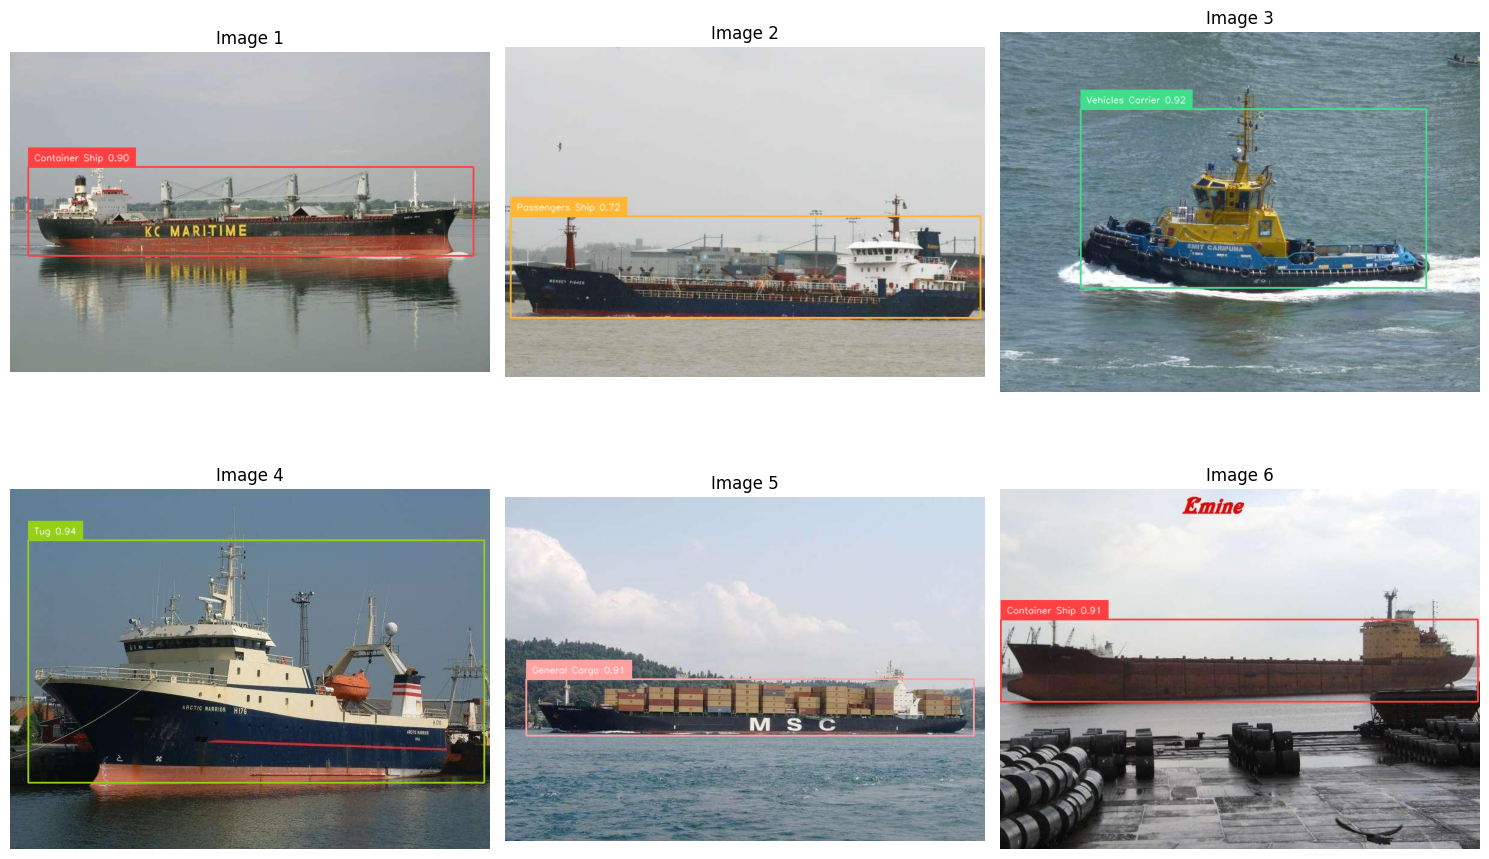

In [88]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv  # using supervision

# Custom ship classes
MY_CLASSES = [
    "Bulk Carrier",
    "Container Ship",
    "General Cargo",
    "Oil Products Tanker",
    "Passengers Ship",
    "Tanker",
    "Trawler",
    "Tug",
    "Vehicles Carrier",
    "Yacht"
]

# Number of images to visualize
NUM_IMAGES = 6
TEST_DIR = "/content/DatasetShips-1/test"

# Get random test images
image_paths = random.sample([
    os.path.join(TEST_DIR, f)
    for f in os.listdir(TEST_DIR)
    if f.endswith(".jpg") or f.endswith(".png")
], NUM_IMAGES)

# Setup grid for plotting
cols = 3
rows = (NUM_IMAGES + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

for i, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert("RGB")

    # Predict
    detections = model.predict(image, threshold=0.5)

    # Remove invalid class IDs (to avoid index errors)
    valid_indices = [
        idx for idx, class_id in enumerate(detections.class_id)
        if 0 <= class_id < len(MY_CLASSES)
    ]
    detections.class_id = [detections.class_id[j] for j in valid_indices]
    detections.confidence = [detections.confidence[j] for j in valid_indices]
    detections.xyxy = [detections.xyxy[j] for j in valid_indices]

    # Convert bbox list to numpy array for supervision
    detections.xyxy = np.array(detections.xyxy)

    # Skip annotation if no detections
    if detections.xyxy.size == 0:
        axs[i].imshow(image)
        axs[i].axis("off")
        axs[i].set_title(f"Image {i+1} (No Detections)")
        continue

    # Create labels
    labels = [
        f"{MY_CLASSES[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    # Annotate image
    annotated = sv.BoxAnnotator().annotate(image.copy(), detections)
    annotated = sv.LabelAnnotator().annotate(annotated, detections, labels)

    # Display
    axs[i].imshow(annotated)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

# Hide unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()


# Evaluation

In [81]:
import json
import os
from PIL import Image
from tqdm import tqdm
from pycocotools.coco import COCO

def generate_coco_predictions(model, image_dir, ann_file, output_json_path):
    coco = COCO(ann_file)
    image_ids = coco.getImgIds()
    predictions = []

    for image_id in tqdm(image_ids):
        info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(image_dir, info['file_name'])

        if not os.path.exists(image_path):
            print(f"Skipping missing image: {image_path}")
            continue

        image = Image.open(image_path).convert("RGB")
        dets = model.predict(image, threshold=0.05)

        if len(dets.xyxy) == 0:
            continue  # Skip images with no detections

        for bbox, score, class_id in zip(dets.xyxy, dets.confidence, dets.class_id):
            x1, y1, x2, y2 = map(float, bbox)
            w, h = x2 - x1, y2 - y1
            predictions.append({
                "image_id": int(image_id),
                "category_id": int(class_id),
                "bbox": [round(x1, 2), round(y1, 2), round(w, 2), round(h, 2)],
                "score": round(float(score), 4)
            })

    if not predictions:
        print("No predictions generated — check your model output or dataset.")
    else:
        with open(output_json_path, "w") as f:
            json.dump(predictions, f)
        print(f"Saved {len(predictions)} predictions to {output_json_path}")


In [82]:
generate_coco_predictions(
    model=model,
    image_dir="/content/DatasetShips-1/test",
    ann_file="/content/DatasetShips-1/test/_annotations.coco.json",
    output_json_path="rfdetr_predictions.json"
)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 500/500 [00:15<00:00, 32.79it/s]

Saved 1166 predictions to rfdetr_predictions.json


In [83]:
from scipy.optimize import linear_sum_assignment
import torch
import json

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

def compute_classification_accuracy(ann_file, pred_file, iou_threshold=0.5):
    from pycocotools.coco import COCO

    coco_gt = COCO(ann_file)
    with open(pred_file, 'r') as f:
        predictions = json.load(f)

    preds_by_image = {}
    for p in predictions:
        preds_by_image.setdefault(p['image_id'], []).append(p)

    correct = 0
    total_matched = 0

    for img_id in coco_gt.getImgIds():
        gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
        gt_boxes = []
        gt_labels = []
        for ann in gt_anns:
            x, y, w, h = ann['bbox']
            gt_boxes.append([x, y, x + w, y + h])
            gt_labels.append(ann['category_id'])

        pred_list = preds_by_image.get(img_id, [])
        pred_boxes = []
        pred_labels = []
        for pred in pred_list:
            x, y, w, h = pred['bbox']
            pred_boxes.append([x, y, x + w, y + h])
            pred_labels.append(pred['category_id'])

        if len(gt_boxes) == 0 or len(pred_boxes) == 0:
            continue

        iou_matrix = torch.zeros((len(gt_boxes), len(pred_boxes)))
        for i, gt in enumerate(gt_boxes):
            for j, pr in enumerate(pred_boxes):
                iou_matrix[i, j] = compute_iou(gt, pr)

        cost_matrix = 1 - iou_matrix.numpy()
        gt_inds, pred_inds = linear_sum_assignment(cost_matrix)

        for gi, pi in zip(gt_inds, pred_inds):
            if iou_matrix[gi, pi] >= iou_threshold:
                total_matched += 1
                if gt_labels[gi] == pred_labels[pi]:
                    correct += 1

    accuracy = correct / total_matched if total_matched > 0 else 0.0
    return accuracy

# Compute classification accuracy
acc = compute_classification_accuracy(
    ann_file="/content/DatasetShips-1/test/_annotations.coco.json",
    pred_file="rfdetr_predictions.json"
)



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [84]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

ann_file = "/content/DatasetShips-1/test/_annotations.coco.json"
pred_file = "rfdetr_predictions.json"

coco_gt = COCO(ann_file)
coco_dt = coco_gt.loadRes(pred_file)

coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.931
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

In [86]:
print(f"Classification Accuracy: {acc:.4f}")

Classification Accuracy: 0.9100
